# Spatial data in Jupyter

For spatial data, the amazing workhorse is GDAL. You might remember this name from RGDAL.
The open-source scientific computing stack is all interlinked.

We will need to start by ensuring you have gdal. So, open up that anaconda prompt/terminal
and do the command "conda install gdal -c conda-forge"

Now import gdal and load a geotiff as a numpy array using GDAL

In [1]:
from osgeo import gdal
import numpy as np
import os, random
geotiff_path = '../../../Data/maize_Production.tif'

First, open the gdal dataset

In [2]:
maize_production_tons_per_cell = gdal.Open(geotiff_path)
print(maize_production_tons_per_cell)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000112E2C12FD0> >


The dataset object holds information about the area and extent of the data, or the geotransform information

In [3]:
geotransform = maize_production_tons_per_cell.GetGeoTransform()
projection = maize_production_tons_per_cell.GetProjection()

print('GDAL dataset geotransform', geotransform)
print('GDAL dataset projection', projection)

GDAL dataset geotransform (-180.0, 0.0833333333333286, 0.0, 89.99999999998977, 0.0, -0.0833333333333286)
GDAL dataset projection GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


IMPORTANT ANNOYING NOTE: in programming, there are different conventions for identifying a place by rows, cols vs. x, y vs. upper-left, lower-right, etc.
Numpy is denoted row, col but gdal is denoted X, Y (which flips the order). Just memorize that row = Y and col = X.

In [4]:
n_rows = maize_production_tons_per_cell.RasterYSize
print('Number of rows in a GDAL dataset', n_rows)

n_cols = maize_production_tons_per_cell.RasterXSize
print('Number of columns in a GDAL dataset', n_cols)

Number of rows in a GDAL dataset 2160
Number of columns in a GDAL dataset 4320


Next, get the "band" of the dataset. Many datasets have multiple layers (e.g. NetCDFs).
Geotiffs can have multiple bands but often have just 1. For now, grab band 1

In [5]:
maize_production_tons_per_cell_band = maize_production_tons_per_cell.GetRasterBand(1)

The band object has information too, like the datatype of the geotiff:

In [6]:
data_type = maize_production_tons_per_cell_band.DataType
no_data_value = maize_production_tons_per_cell_band.GetNoDataValue()

print('data_type', data_type)
print('no_data_value', no_data_value)

data_type 6
no_data_value -9999.0


Finally, we can get the array from the band as a numpy array:

In [7]:
array = maize_production_tons_per_cell_band.ReadAsArray()
shape = array.shape

print('Look at the array itself', array)

Look at the array itself [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


But let's make it pretty.

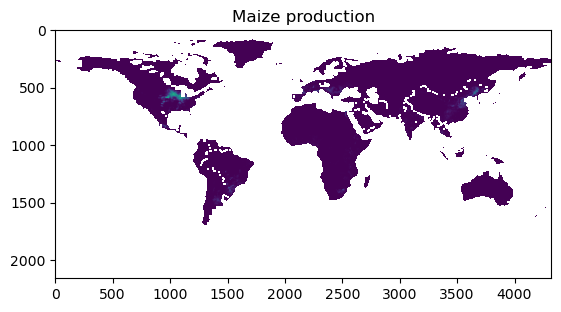

In [8]:

import matplotlib.pyplot as plt

plt.imshow(array)
plt.title('Maize production')

# COMMON MISTAKE HERE: plt.show() will clear what's in plt, so if you want to save it, do so before the plt.show()
plt.savefig('maize.png', dpi=300) 
plt.show()

Other things you can do are use the numpy vectorized (fast) functions just like with Pandas.
However, spatial data often have Not-a-Number NaN Values

In [9]:
print('Add up the array', np.sum(array))

Add up the array nan


We can fix this with np.nansum()

In [10]:
print('Add up the nan array', np.nansum(array))

Add up the nan array 593478850.0


Additionally, we could do it manually by
creating a logical mask array, which would have a True False value for each pixel
depending on nan status. Numpy of course has a builtin functino for this.

In [11]:
mask = np.isnan(array)

You could also use this mask to assign a value. Here we replace all NaNs with zero

In [12]:
array[mask] = 0.0

In [13]:
print('Add up the masked array', np.sum(array))

Add up the masked array 593478850.0


In [14]:
array = np.where(mask, 0, array)

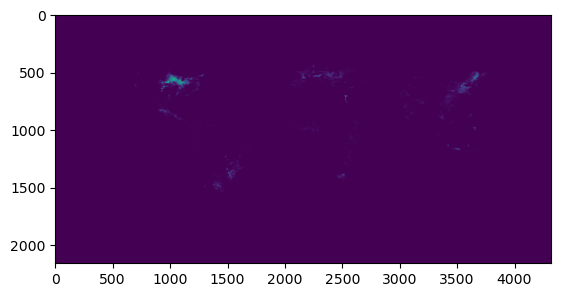

In [15]:
plt.imshow(array)
plt.show()

A common task is to want to see each unique value in an array. As below.

In [16]:
values, counts = np.unique(array, return_counts=True)
print(values)
print(counts)

[0.0000000e+00 3.9654671e-09 5.1801510e-09 ... 4.8260012e+04 4.8770938e+04
 4.9431621e+04]
[8530133       1       1 ...       1       1       1]


# BIG DATA IMPLICATION: Copies versus Views in mumpy.
Make a copy in memory for us to play with.
NOTE that if we just did c_view = c and then modified c_view,
the c array would also be changed.

This only creates a new pointer to the same block of memory on your computer that holds the array. If we change c_view, c will also be changed.

In [17]:
c_view = array

This gives us a NEW array in a new block of memory, so changing c_calcs will not change c.

In [18]:
d = array.copy()

QUICK REVIEW ON ARRAY NOTATION, which is identical from before for 2-dim arrays.
Get specific elements in the array with [row, col]
specific_value = d[400, 500]

Or you can get values between a range of rows and cols with :
chunk_of_array = d[1000:1100, 1600:1700] # This would give you a 100 by 100 subarray

 Note, unlike vanilla python, Numpy conditionals here must use & and must be in parenthases.
d[(d > 200) & (d < 10000)] = 33

In [19]:
print('The sum of d after we messed with it', np.sum(d))

The sum of d after we messed with it 593478850.0


Save the as a new geotiff to disk

Create a new filename for our output file. The + concatenates things. Str() makes the number a string.
This is one of those cases where python wouldn't correctly guess the data type

In [20]:
output_filename = 'gdal_created_array_' + str(random.randint(1, 1000000)) + '.tif'

Create a new file at that filename location using the attributes we used above
Notice that we flipped n_cols and n_rows from how numpy would have wanted it.

In [21]:
output_dataset = gdal.GetDriverByName('GTiff').Create(output_filename, d.shape[1], d.shape[0], 1, 6)

Set dataset-level information

In [22]:
output_dataset.SetGeoTransform(geotransform)
output_dataset.SetProjection(projection)

0

Now get a band from our new dataset on which we'll write our array.

In [23]:
output_band = output_dataset.GetRasterBand(1)

Do the array writing

In [24]:
output_band.WriteArray(d)

0

Set any final band-level information

In [25]:
output_band.SetNoDataValue(no_data_value)

0

Finally, and very importantly, clean up after yourself. It wont actually write until the resources in
memory have been released.

In [26]:
d = None
output_band = None
output_dataset = None




